# Environment Module - LocalDescriptors
The `freud.environment` module analyzes the local environments of particles. The `freud.environment.LocalDescriptors` class is a useful tool for analyzing identifying crystal structures in a rotationally invariant manner using local particle environments. The primary purpose of this class is to compute spherical harmonics between neighboring particles in a way that orients particles correctly relative to their local environment, ensuring that global orientational shifts do not change the output.

In [1]:
import freud
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import util
%matplotlib notebook

For simplicity, we consider points on a simple cubic lattice.

Text(0.5,0.92,'Simple cubic crystal')

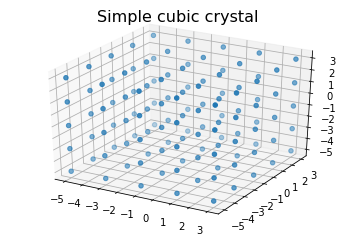

In [3]:
box, points = util.make_sc(5, 5, 5)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_title("Simple cubic crystal", fontsize=16);

Now, let's use the class to compute an array of spherical harmonics for the system.
The harmonics are computed for each bond, where a bond is defined by a pair of particles that are determined to lie within each others' nearest neighbor shells based on a standard neighbor list search.
The number of bonds and spherical harmonics to calculate is configurable.

In [ ]:
orientations = np.array([1, 0, 0, 0])

In [13]:
num_neighbors = 6
l_max = 12
r_max = 2
ld = freud.environment.LocalDescriptors(num_neighbors, l_max, r_max)

The resulting spherical harmonic array has a shape corresponding to the number of neighbors

In [16]:
sph_raw = np.mean(ld.compute(box, num_neighbors, points, mode='global').sph, axis=0)
count = 0
sph = np.zeros((l_max+1, l_max+1), dtype=np.complex128)
for l in range(13):
    for m in range(-l, l+1):
        sph[l, m] = sph_raw[count]

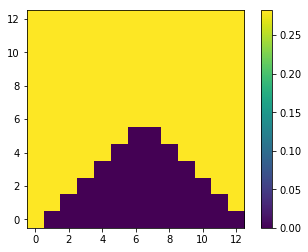

In [17]:
fig, ax = plt.subplots()
im = ax.imshow(np.absolute(sph), origin='lower')
plt.colorbar(im);

Now rotate points and show it's the same.

In [ ]:
def multiply(qi, qj):
    """Multiply quaternions."""
    qi = np.asarray(qi)
    qj = np.asarray(qj)

    output = np.empty(np.broadcast(qi, qj).shape)
    output[..., 0] = qi[..., 0] * qj[..., 0] - \
        np.sum(qi[..., 1:] * qj[..., 1:], axis=-1)
    output[..., 1:] = (qi[..., 0, np.newaxis] * qj[..., 1:] +
                       qj[..., 0, np.newaxis] * qi[..., 1:] +
                       np.cross(qi[..., 1:], qj[..., 1:]))
    return output

def rotate(q, v):
    """Rotate vectors by quaternions."""
    q = np.asarray(q)
    v = np.asarray(v)

    # Convert vector to quaternion representation
    quat_v = _promote_vec(v)
    return multiply(q, multiply(quat_v, conjugate(q)))[..., 1:]

In [27]:
import rowan
help(rowan.from_axis_angle)
rowan.from_axis_angle(np.deg2rad(41))

Help on function from_axis_angle in module rowan.functions:

from_axis_angle(axes, angles)
    Find quaternions to rotate a specified angle about a specified axis.
    
    Args:
        axes ((...,3) np.array): An array of vectors (the axes).
        angles (float or (...,1) np.array): An array of angles in radians.
            Will be broadcast to match shape of v as needed.
    
    Returns:
        Array of shape (..., 4) containing the corresponding rotation
        quaternions.
    
    Example::
    
        quat = rowan.from_axis_angle([[1, 0, 0]], np.pi/3)



TypeError: from_axis_angle() missing 1 required positional argument: 'angles'

In [18]:
theta = np.deg2rad(41)
rotation = np.array([[1, 0, 0],
                    [0, np.cos(theta), -np.sin(theta)],
                    [0, np.sin(theta), np.cos(theta)]])
rotated_points = points.dot(rotation.T)

In [19]:
rotated_ld = freud.environment.LocalDescriptors(num_neighbors, l_max, r_max)


In [20]:
sph_rotated_raw = np.mean(rotated_ld.compute(box, 6, box.wrap(rotated_points), mode='global').sph, axis=0)
count = 0
sph_rotated = np.zeros((l_max+1, l_max+1), dtype=np.complex128)
for l in range(13):
    for m in range(-l, l+1):
        sph_rotated[l, m] = sph_rotated_raw[count]

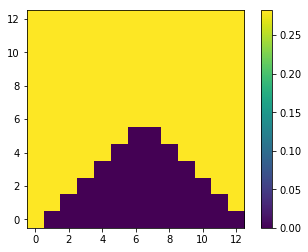

In [21]:
fig, ax = plt.subplots()
im = ax.imshow(np.absolute(sph_rotated), origin='lower')
plt.colorbar(im)